## Install required dependencies

In [25]:
%%bash
# If your project has a 'requirements.txt' file, we'll install it here.
if test -f requirements.txt
  then
    pip install -r ./requirements.txt
  else echo "There's no requirements.txt, so nothing to install."
fi

## Import dataset

In [26]:
import polars as pl
import polars.selectors as cs
from datetime import date

# import dataset
df = pl.scan_csv('data/aida_data.csv')

# Read accounting closing data as a date
df = df.with_columns(
    pl.col("Last accounting closing date").str.to_date("%d/%m/%Y", strict=False)
)

In [27]:
# Correctly interpret comma decimal separator as point
df = df.with_columns(((cs.ends_with("2014") | cs.ends_with("2015")) & cs.string()).str.replace(",", ".").cast(pl.Float32))

## Filter and create variables of interest

In [28]:
# define bounds of the study
starting_date = date(2015,12,31)
ending_date = date(2018,12,31)

df = (
    df.filter(pl.col("Last accounting closing date") >= starting_date)
    .with_columns(
        # create date of bankruptcy as date of last balance sheet + 1
        date = pl.when(pl.col("Last accounting closing date")>ending_date)
        .then(ending_date.year+1)
        .otherwise(pl.col("Last accounting closing date").dt.year()+1))
)

df = (
    df.with_columns(
        # create target variable distance and status
        distance = pl.col("date")-starting_date.year,
        status = pl.when(
            ((pl.col("Legal status") == "Bankruptcy") | (pl.col("Legal status") == "Dissolved (bankruptcy)")) 
            & (pl.col("Last accounting closing date")<=ending_date))
            .then(True).otherwise(False), # status is the opposite of censored
    )
)

Create company size from thresholds of Number of Employees 2015 column.

In [29]:
import pandas as pd


df = df.collect()
df = df.with_columns(size=pl.from_pandas(pd.cut(df['Number of employees 2015'].to_pandas(), [0, 5, 50, float("inf")], labels=["micro", "small", "medium-large"], include_lowest=True)))

print(
    df
    .group_by("size")
    .agg(
        pl.col("Number of employees 2015").count().alias("count"),
        pl.col("Number of employees 2015").min().alias("min"),
        pl.col("Number of employees 2015").max().alias("max")
    )
)

df = df.lazy()

shape: (3, 4)
┌──────────────┬───────┬─────┬────────┐
│ size         ┆ count ┆ min ┆ max    │
│ ---          ┆ ---   ┆ --- ┆ ---    │
│ cat          ┆ u32   ┆ i64 ┆ i64    │
╞══════════════╪═══════╪═════╪════════╡
│ micro        ┆ 78812 ┆ 0   ┆ 5      │
│ small        ┆ 64175 ┆ 6   ┆ 50     │
│ medium-large ┆ 14082 ┆ 51  ┆ 135514 │
└──────────────┴───────┴─────┴────────┘


## Retrieve macro letter code from ATECO digits

To retrieve the macro letter code from the ATECO digits, we take the first two digits and we look for those in the structure database of the ATECO codes imported as an Excel file. However, the layout of the file is weird and we need a loop to sort things out.

In [30]:
import polars as pl

df = df.with_columns(
    # create variable for the first two digits of the ateco code
    ateco_two_digits = pl.col("ATECO 2007 code").cast(pl.Utf8).str.zfill(6).str.slice(0, 2)
)

In [31]:
import polars as pl

df = df.with_columns(
    pl.col("ateco_two_digits").replace("00", None)
)

# df = df.drop_nulls(subset="ateco_two_digits")

In [32]:
import re

ateco_def = pl.read_excel("data/Struttura-ATECO-2007-aggiornamento-2022.xlsx").lazy()
ateco_def = ateco_def.rename({"Codice\nAteco 2007\naggiornamento 2022": "ateco_code", "Titolo Ateco 2007 aggiornamento 2022": "ateco_title"})

strus = ateco_def.collect().filter(~pl.col("ateco_code").str.contains(".", literal=True))

letters = []
codes = []

letter = None

for row in strus.rows(named=True):
    code = row["ateco_code"]

    if re.match("\d", code):
        codes.append(code)
        if letter:
            letters.append(letter)
    else:
        letter = code

strus = pl.LazyFrame({"letters": letters, "codes": codes})

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/xt/lhm63r313pb6qy47s2z12bzh0000gn/T/ipykernel_45898/4255111337.py:16: SyntaxWarning: invalid escape sequence '\d'
  if re.match("\d", code):


In [33]:
ateco_def = ateco_def.join(strus, left_on="ateco_code", right_on="letters")

In [34]:
import polars.selectors as cs

atecos = df.lazy().join(ateco_def.lazy(), left_on="ateco_two_digits", right_on="codes", how="left")
atecos = atecos.group_by("ateco_code").agg((cs.float() & cs.ends_with("2015")).mean(), pl.col("CCIAA number").count()).sort("CCIAA number")
atecos = atecos.filter(pl.col("CCIAA number") > 20).collect()

In [35]:
df = df.join(ateco_def, left_on="ateco_two_digits", right_on="codes", how="left").join(atecos.lazy().select("ateco_code"), on="ateco_code", how="outer")
df = df.collect()

## Check for NAs

In [36]:
df.select(pl.all().is_null().sum()).to_dicts()[0]

{'Mark': 0,
 'Company name': 0,
 'Province': 0,
 'CCIAA number': 0,
 'Current ratio 2014': 0,
 'Current ratio 2015': 0,
 'Interest/Operating profit % 2014': 0,
 'Interest/Operating profit % 2015': 0,
 'Working capital to total assets 2014': 0,
 'Working capital to total assets 2015': 0,
 'Return on asset (ROA) % 2014': 0,
 'Return on asset (ROA) % 2015': 0,
 'Sales to total assets 2014': 0,
 'Sales to total assets 2015': 0,
 'Stocks/Turnover (days) 2014': 0,
 'Stocks/Turnover (days) 2015': 0,
 'Leverage 2014': 0,
 'Leverage 2015': 0,
 'Return on sales (ROS) % 2014': 0,
 'Return on sales (ROS) % 2015': 0,
 'Cash to total assets 2014': 0,
 'Cash to total assets 2015': 0,
 'Current liabilities/Tot ass. % 2014': 0,
 'Current liabilities/Tot ass. % 2015': 0,
 'Working cap. turnover (times) 2014': 0,
 'Working cap. turnover (times) 2015': 0,
 'Cash to current liabilities 2014': 0,
 'Cash to current liabilities 2015': 0,
 'Short term debt to equity 2014': 0,
 'Short term debt to equity 2015':

In [37]:
df_with_na = df

Drop the NAs in ateco_code_right, which are the missing or excluded ATECO codes.

In [38]:
df = df.drop_nulls(subset="ateco_code_right")

Export df at this point so outliers can be represented. Later, they will be removed.

In [39]:
df_with_outliers = df
%store df_with_outliers

Stored 'df_with_outliers' (DataFrame)


## Handling of outliers

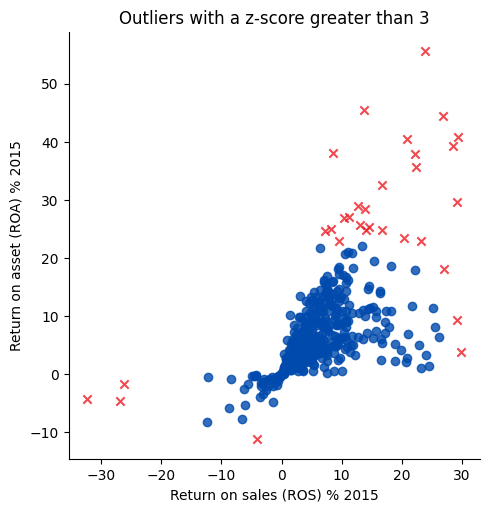

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dfa = df.to_pandas()
# Set point as outlier if it has a z-score >= 3 for ROA or ROS
dfa['outlier'] = ((np.abs((dfa['Return on sales (ROS) % 2015'] - dfa['Return on sales (ROS) % 2015'].mean()) / dfa['Return on sales (ROS) % 2015'].std(ddof=0)) >= 3) | 
(np.abs((dfa['Return on asset (ROA) % 2015'] - dfa['Return on asset (ROA) % 2015'].mean()) / dfa['Return on asset (ROA) % 2015'].std(ddof=0)) >= 2))

custom = ["#004aad", "#ed1c24"]
sns.set_palette(custom)
sns.lmplot(data=dfa.sample(500, random_state=2054), legend=False, fit_reg=False, 
    x="Return on sales (ROS) % 2015", y="Return on asset (ROA) % 2015", hue="outlier", 
    markers=["o", "x"]);
plt.xlim=([-14, 30])
plt.ylim=([-15, 50])
plt.title("Outliers with a z-score greater than 3") 
plt.show() 

### Let's drop them

Let's check the shape before and after the drop of outliers.

In [41]:
from scipy import stats
import polars as pl
import polars.selectors as cs
import numpy as np

print(df.shape)
dfp = df.to_pandas()
df_sub = df.select((cs.ends_with("2014") | cs.ends_with("2015")) & cs.float()).to_pandas()
cols = df_sub.columns

lim = np.abs(stats.zscore(df_sub)) < 3

dfp.loc[:, cols] = df_sub.where(lim, np.nan)

df = pl.from_pandas(dfp.dropna(subset=cols))

print(df.shape)

(157052, 51)
(117505, 51)


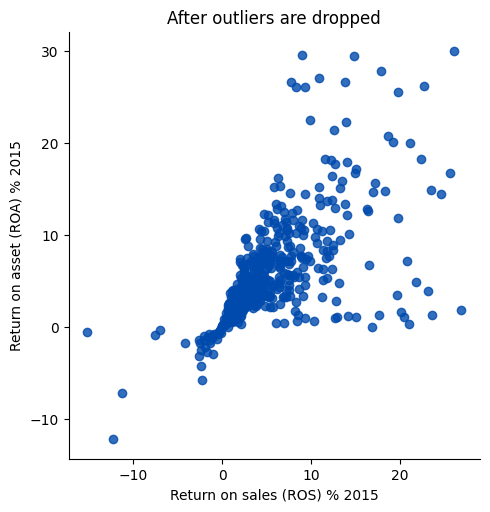

In [42]:
custom = ["#004aad"]
sns.set_palette(custom)
sns.lmplot(data=df.to_pandas().sample(500, random_state=2054), legend=False, fit_reg=False, x="Return on sales (ROS) % 2015", y="Return on asset (ROA) % 2015");
plt.xlim=([-14, 30])
plt.ylim=([-15, 50])
plt.title("After outliers are dropped") 
plt.show() 

## X and Y creation and hot encoding

In [43]:
import polars as pl
import polars.selectors as cs

# select all the financial ratios as X + company size + ateco_code
X = df.select((cs.ends_with("2014") | cs.ends_with("2015")) & cs.float()|pl.col("size")|pl.col("ateco_code"))
X = X.with_columns(pl.col("ateco_code", "size").cast(pl.Categorical))

# select status and distance as Y
Y = df.select(pl.col("status", "distance"))

print("X and Y shapes are", X.shape, Y.shape)

X and Y shapes are (117505, 34) (117505, 2)


In [44]:
from sksurv.preprocessing import OneHotEncoder

# hot-encode
X = pl.from_pandas(OneHotEncoder().fit_transform(X.to_pandas()))
X

Current ratio 2014,Interest/Operating profit % 2014,Working capital to total assets 2014,Return on asset (ROA) % 2014,Sales to total assets 2014,Stocks/Turnover (days) 2014,Leverage 2014,Return on sales (ROS) % 2014,Cash to total assets 2014,Current liabilities/Tot ass. % 2014,Working cap. turnover (times) 2014,Cash to current liabilities 2014,Short term debt to equity 2014,Long-term liabilities to asset 2014,Net income to total assets 2014,Retained earning to total assets 2014,Current ratio 2015,Interest/Operating profit % 2015,Working capital to total assets 2015,Return on asset (ROA) % 2015,Sales to total assets 2015,Stocks/Turnover (days) 2015,Leverage 2015,Return on sales (ROS) % 2015,Cash to total assets 2015,Current liabilities/Tot ass. % 2015,Working cap. turnover (times) 2015,Cash to current liabilities 2015,Short term debt to equity 2015,Long-term liabilities to asset 2015,Net income to total assets 2015,Retained earning to total assets 2015,size=small,size=medium-large,ateco_code=N,ateco_code=Q,ateco_code=F,ateco_code=G,ateco_code=J,ateco_code=I,ateco_code=M,ateco_code=H,ateco_code=R,ateco_code=A,ateco_code=S,ateco_code=L,ateco_code=K,ateco_code=D,ateco_code=P,ateco_code=E,ateco_code=B
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.39,14.57,0.89,6.52,1.68,37.439999,5.47,3.88,0.0,0.86,1.81,0.0,3.5,0.11,0.03,0.0,1.37,9.43,0.91,6.5,1.75,29.110001,5.6,3.72,0.0,0.87,1.91,0.0,3.75,0.1,0.03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9,89.980003,0.69,2.85,1.11,0.0,2.93,2.56,0.0,0.55,1.47,0.0,1.06,0.29,0.03,-0.06,1.59,39.110001,0.82,-2.35,1.1,0.0,3.4,-2.13,0.0,0.73,1.01,0.0,1.75,0.19,-0.03,-0.03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.45,80.120003,0.37,21.139999,1.44,0.0,3.87,14.73,0.0,0.21,3.85,0.03,0.59,0.57,0.12,0.06,0.86,47.619999,0.4,26.370001,1.01,0.0,3.64,26.110001,0.02,0.67,2.5,0.04,1.71,0.24,0.16,0.08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.01,10.13,0.96,10.09,1.6,4.64,6.63,6.3,0.14,0.42,1.67,0.44,2.11,0.45,0.05,0.07,3.1,6.94,0.91,11.83,1.74,4.15,5.11,6.8,0.08,0.41,1.92,0.29,1.5,0.42,0.05,0.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.8,62.939999,0.72,5.09,1.25,112.419998,12.81,4.06,0.05,1.0,1.72,0.06,11.64,0.0,0.03,0.04,0.78,30.940001,0.68,5.62,2.45,63.380001,8.86,2.3,0.03,1.0,3.56,0.04,7.74,0.0,0.03,0.07,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.98,14.66,0.64,3.25,0.63,238.139999,1.55,5.12,0.0,1.0,0.99,0.0,0.5,0.0,0.03,0.0,2.17,26.93,0.62,2.53,0.65,258.209991,1.47,3.91,0.0,1.0,1.04,0.0,0.42,0.0,0.02,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.98,13.37,0.95,1.08,1.43,0.0,49.25,0.75,0.0,1.0,1.5,0.0,48.110001,0.0,0.0,0.0,1.0,50.240002,0.96,3.58,3.84,0.0,27.74,0.93,0.0,1.0,3.99,0.0,26.709999,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.45,2.34,0.82,4.39,0.78,111.449997,4.23,5.61,0.0,0.86,0.92,0.0,2.39,0.1,0.01,0.0,1.25,3.01,0.84,8.86,1.35,67.769997,3.99,6.55,0.0,0.99,1.57,0.0,2.66,0.01,0.04,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training, validation, test sets

Also train_val set is created which is the union between training and validation with balancing and standardizing done. This is used for cross-validation.

In [45]:
from sklearn.model_selection import train_test_split

random_state = 2054

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size=test_ratio + validation_ratio, random_state=random_state)

print(f"Training set size is {round(len(X_train)/len(X), 2)}, {round(len(Y_train)/len(Y), 2)}")

train = pl.concat([X_train, Y_train], how="horizontal")

X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=random_state) 

print(f"Validation set size is {round(len(X_val)/len(X), 2)}, {round(len(Y_val)/len(Y), 2)}")
print(f"Test set size is {round(len(X_test)/len(X), 2)}, {round(len(Y_test)/len(Y), 2)}")

val = pl.concat([X_val, Y_val], how="horizontal")
train_val = pl.concat([train, val])

print(f"Val/Test set size is {round(len(X_val_test)/len(X), 2)}, {round(len(Y_val_test)/len(Y), 2)}")

Training set size is 0.6, 0.6
Validation set size is 0.2, 0.2
Test set size is 0.2, 0.2
Val/Test set size is 0.4, 0.4


## Risk-set balancing

In survival analysis models, balancing works differently than a normal prediction model. The majority and minority classes are not to be found in status column, whether the observation is uncensored or censored, but depends on the number of failures at each distinct failure time 𝑡∗ with respect to all those who have not yet failed by that time.

Langholz, B., & Goldstein, L. (1996). Risk set sampling in epidemiologic cohort studies. Statistical Science, 35-53.

In [46]:
# build custom function from Langholz, B., & Goldstein, L. (1996). Risk set sampling in epidemiologic cohort studies. Statistical Science, 35-53.

# Define a function to sample non-failures at each risk set
def risk_set_sampling(df):
    # Create an empty dataframe to store the sampled data
    sampled_df = pl.DataFrame()
    # Loop over the unique failure times
    for t in df.filter("status")["distance"].unique():
        # Get the number of failures at time t (the CASE): we take ALL of them
        failures = df.filter((pl.col("distance") == t) & (pl.col("status")))

        # Get the risk set at time t, i.e. those who have not failed before t
        risk_set = df.filter(pl.col("distance") >= t)
        # Sample n_failures non-failures (CONTROLS) from the risk set
        sampled_non_failures = risk_set.filter(pl.col("status") == False).sample(len(failures)*5, seed=random_state)
        
        # Concatenate the failures and non-failures at time t
        sampled_df = pl.concat([sampled_df, failures, sampled_non_failures])
    # Return the sampled dataframe
    return sampled_df

# risk-set sampling on the training
train_sampled = risk_set_sampling(train)
X_train = train_sampled.select(pl.exclude("status", "distance"))
Y_train = train_sampled.select("status", "distance")

# risk-set sampling on the train-val for the cross-validation
train_val_sampled = risk_set_sampling(train_val)

X_train_val = train_val_sampled.select(pl.exclude("status", "distance"))
Y_train_val = train_val_sampled.select("status", "distance")

## Standard scaling

In [47]:
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()

X_train_scaled = scaling.fit_transform(X_train)
X_train_val_scaled = scaling.fit_transform(X_train_val)
X_val_scaled = scaling.fit_transform(X_val)
X_test_scaled = scaling.fit_transform(X_test)

## Store all variables for running other notebooks

In [48]:
%store df
%store X_train_scaled
%store Y_train
%store X_val_scaled
%store Y_val
%store X_test_scaled
%store Y_test
%store X_train
%store X_train_val_scaled
%store Y_train_val
%store X_test

Stored 'df' (DataFrame)
Stored 'X_train_scaled' (ndarray)
Stored 'Y_train' (DataFrame)
Stored 'X_val_scaled' (ndarray)
Stored 'Y_val' (DataFrame)
Stored 'X_test_scaled' (ndarray)
Stored 'Y_test' (DataFrame)
Stored 'X_train' (DataFrame)
Stored 'X_train_val_scaled' (ndarray)
Stored 'Y_train_val' (DataFrame)
Stored 'X_test' (DataFrame)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cda3dc7f-2383-4ca3-97fb-1b86671fd3dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>